# A programming introduction to GANs

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

## Introduction


This is a post about Generative Adversarial Networks (GANs). This post is very heavily influenced and borrows code from:

- [Video from Luis Serrano](https://www.youtube.com/watch?v=8L11aMN5KY8)
- Heavily borrowed code from this [article]( https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) on machine learning mastery


These folks deserve all the credit! I am writing this post mostly for my learning.

I'd highly recommend reading the above two mentioned resources.

## Goal

The goal of GANs is to generate [realistic data](https://en.wikipedia.org/wiki/Generative_adversarial_network), i.e. data with similar statistics as the training data. 

See below a "generated" face on https://thispersondoesnotexist.com

Refresh this page to get a new face each time!

These are people that do not exist but their faces have been generated using GANs.

In [1]:
from IPython.display import HTML, IFrame
IFrame("https://thispersondoesnotexist.com", 400, 400)

## Overall Block Diagram

Conceptually, GANs are simple.They have two main components:

- A discriminator: that tries to accurately tell generated and real data (from training data) apart
- A generator: that generates data given some random numbers

The goal of GANs is to use the generator to create realistic data such that the discriminator thinks it is real (coming from the training dataset)


![](GAN-1.jpg)

The two components discriminator and generator are "fighting" where:

- the goal of the discriminator is to tell apart fake (generated) data from true data (from training set) even when the generator is fairly good
- the goal of the generator is to generate realistics data such that the discriminator thinks it is real data

![](GAN-2.jpg)

## Creating "true" distribution

Let us now create some data from the true/known distribution. We will be essentially creating a 2x2 matrix (image) as explained in Luis Serrano's tutorial. The (0, 0) and (1, 1) position will be a high number between 0.8 and 1 whereas the other two positions (0, 1) and (1, 0) have values between 0 and 0.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media

%matplotlib inline
np.random.seed(40)
import warnings
warnings.filterwarnings('ignore')
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import tensorflow as tf   
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(42)

In [3]:
SIZE = 5000
faces = np.vstack((np.random.uniform(0.8, 1, SIZE), 
                   np.random.uniform(0., 0.1, SIZE),
                  np.random.uniform(0., 0.1, SIZE),
                  np.random.uniform(0.8, 1, SIZE))).T
faces.shape

(5000, 4)

In [4]:
def plot_face(f):
    f_reshape = f.reshape(2, 2)
    plt.imshow(f_reshape, cmap="Greys")

In [5]:
def plot_faces(faces, subset=1):
    images = {
        f'Image={im}': faces[im].reshape(2, 2)
        for im in range(len(faces))[::subset]
    }
    media.show_images(images, border=True, columns=8, height=80, cmap='Greys')

plot_faces(faces, subset=700)

Image=0,Image=700,Image=1400,Image=2100,Image=2800,Image=3500,Image=4200,Image=4900


The above shows some samples drawn from the true distibution. Let us also now create some random/noisy samples. These samples do not have any relationship between the 4 positions. 

In [6]:

# Examples of noisy images
noise = np.random.randn(40, 4)
noise = np.abs(noise)
noise = noise/noise.max()

In [7]:
plot_faces(noise)

Image=0,Image=1,Image=2,Image=3,Image=4,Image=5,Image=6,Image=7
Image=8,Image=9,Image=10,Image=11,Image=12,Image=13,Image=14,Image=15
Image=16,Image=17,Image=18,Image=19,Image=20,Image=21,Image=22,Image=23
Image=24,Image=25,Image=26,Image=27,Image=28,Image=29,Image=30,Image=31
Image=32,Image=33,Image=34,Image=35,Image=36,Image=37,Image=38,Image=39


## Creating the discriminator

Our discriminator is simple. 

- It accepts as input a 4 dimensional input (the 2x2 image) 
- It outputs a single number with sigmoid activation denoting the probability of: 
 - image being fake or generated by generator or belonging to class 0
 - image being real or sampled from training dataset or belonging to class 1
- We use the binary cross entropy loss


To make the above crystal clear, I'll use the following [gist](https://gist.github.com/craffel/2d727968c3aaebd10359) to draw this NN

In [8]:
from draw_nn import draw_neural_net

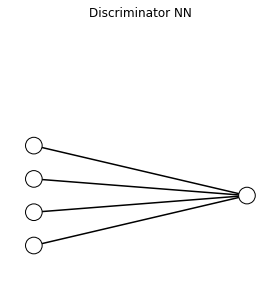

In [9]:
fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, 0.9, .1, .6, [4, 1])
plt.tight_layout()
plt.title("Discriminator NN");

In [10]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

discriminator = Sequential([
  Dense(1,activation='sigmoid', input_shape=(4, )),
])

discriminator._name = "Discriminator"

discriminator.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy'
)


In [11]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


As expected, the discriminator has 5 parameters (4 weights coming from the 4 inputs to the output node and 1 bias term added). Now, let us create the generator.

## Creating the generator

Let us now create the generator model. We create a very simple one

- It accepts as input a single random number
- It creates a vector of size 4

The illustration below shows this network. It should be noted that the single random input is an arbitrary choice. We could use any number really!  

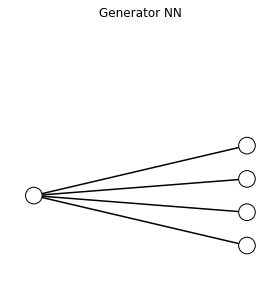

In [12]:
fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, 0.9, .1, .6, [1, 4])
plt.tight_layout()
plt.title("Generator NN");

In [13]:
from keras.layers import ReLU
generator = Sequential([
  Dense(4, input_shape=(1, )),
   ReLU(max_value=1.0) 

])

generator._name = "Generator"

generator.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy'
)

In [14]:
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 8         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 4)                 0         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


We can verify that the network has 8 parameters (4 weights and one bias value per output node)

## Generating samples from Generator

We can now use our generator to generate some samples and plot them.

In [15]:
def gen_fake(n_samples):
    x_input = np.random.randn(n_samples, 1)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

As expected, the samples look random, without any specific pattern and do not resemble the training data as our generator is untrained. Further, it is important to reiterate that the class associated with the fake samples generated from the generator is 0. Thus, we have the line `np.zeros((n_samples, 1))` in the code above.

In [16]:
plot_faces(gen_fake(20)[0])

## Sampling from the Real (Train) Dataset

In [17]:
def gen_real(n_samples):
    ix = np.random.randint(0, faces.shape[0], n_samples)
    X = faces[ix]
    y = np.ones((n_samples, 1))
    return X, y

In [18]:
plot_faces(gen_real(20)[0])

We can clearly see the pattern in the images coming from the training dataset.

## Training the GAN

The block diagram below shows the main idea behind training GANs. The procedure is similar to alternative least squares. 

![](GAN-3.jpg)

In [19]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [20]:
gan_model = define_gan(generator, discriminator)

It is important to note that we will train two networks:

- Discriminator on 
 - Fake data (class 0)
 - Real data (class 1)
- Combined model consisting og Generator + Discriminator (where the Discriminator is is fixed) on
 - Fake data (class 0) posing as real data (class 1) to the model
 
Thus, we do not train on the generator separately. 

In [21]:
samples_saved = {}
losses = {}
N_ITER = 1000
STEP = N_ITER//10
for i in range(N_ITER):
    # Generate some fake data
    X_fake, y_fake = gen_fake(2)
    X_real, y_real = gen_real(2)
    
    X, y = np.vstack((X_fake, X_real)), np.vstack((y_fake, y_real))
    
    # Discriminator 
    d_loss = discriminator.train_on_batch(X, y)
        
    # Generator
    n_samples = 4
    g_loss= gan_model.train_on_batch(np.random.randn(n_samples, 1), np.ones(n_samples))
    losses[i] = {'Gen. loss':g_loss, 'Disc. loss':d_loss}
    
    # Save 5 samples
    samples_saved[i]= gen_fake(5)[0]
    
    if i%STEP==0:
        # Save model
        generator.save(f"models/gen-{i}")
        print("")
        print("Iteration: {}".format(i))
        
        print("Discriminator loss: {:0.2f}".format(d_loss))


        print("Generator loss: {:0.2f}".format(g_loss))




Iteration: 0
Discriminator loss: 0.61
Generator loss: 0.72



Iteration: 100
Discriminator loss: 0.61
Generator loss: 0.75



Iteration: 200
Discriminator loss: 0.59
Generator loss: 0.76



Iteration: 300
Discriminator loss: 0.57
Generator loss: 0.72



Iteration: 400
Discriminator loss: 0.60
Generator loss: 0.77



Iteration: 500
Discriminator loss: 0.61
Generator loss: 0.68



Iteration: 600
Discriminator loss: 0.64
Generator loss: 0.66



Iteration: 700
Discriminator loss: 0.60
Generator loss: 0.71



Iteration: 800
Discriminator loss: 0.65
Generator loss: 0.66



Iteration: 900
Discriminator loss: 0.70
Generator loss: 0.63


## Convergence

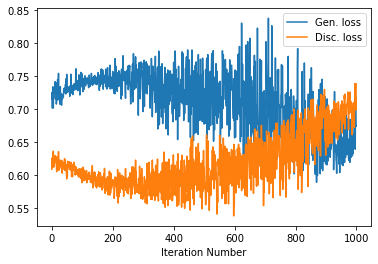

In [22]:
import pandas as pd
losses_df = pd.DataFrame(losses)
losses_df.T.plot();
plt.xlabel("Iteration Number");

You might epxect that over time the generator loss reduces as it becomes better and correspodingly the discriminator has a harder time!

## Generating some "fake" images from the trained generator


In [23]:
plot_faces(gen_fake(20)[0])

You could not tell, right! The generator has been trained well! 

## Visualising evolution of generator

Let us now visualise the evolution of the generator. To do so, we use the already saved generator models at different iterations and feed them the same "random" input.

In [24]:
o = {}
for i in range(0, N_ITER, STEP):
    for inp in [0., 0.2, 0.4, 0.6, 1.]:
        o[f'It:{i}-Inp:{inp}'] = load_model(f"models/gen-{i}").predict(np.array([inp])).reshape(2, 2)

In [26]:
media.show_images(o,  border=True, columns=5, height=80, cmap='Greys')

It:0-Inp:0.0,It:0-Inp:0.2,It:0-Inp:0.4,It:0-Inp:0.6,It:0-Inp:1.0
It:100-Inp:0.0,It:100-Inp:0.2,It:100-Inp:0.4,It:100-Inp:0.6,It:100-Inp:1.0
It:200-Inp:0.0,It:200-Inp:0.2,It:200-Inp:0.4,It:200-Inp:0.6,It:200-Inp:1.0
It:300-Inp:0.0,It:300-Inp:0.2,It:300-Inp:0.4,It:300-Inp:0.6,It:300-Inp:1.0
It:400-Inp:0.0,It:400-Inp:0.2,It:400-Inp:0.4,It:400-Inp:0.6,It:400-Inp:1.0
It:500-Inp:0.0,It:500-Inp:0.2,It:500-Inp:0.4,It:500-Inp:0.6,It:500-Inp:1.0
It:600-Inp:0.0,It:600-Inp:0.2,It:600-Inp:0.4,It:600-Inp:0.6,It:600-Inp:1.0
It:700-Inp:0.0,It:700-Inp:0.2,It:700-Inp:0.4,It:700-Inp:0.6,It:700-Inp:1.0
It:800-Inp:0.0,It:800-Inp:0.2,It:800-Inp:0.4,It:800-Inp:0.6,It:800-Inp:1.0
It:900-Inp:0.0,It:900-Inp:0.2,It:900-Inp:0.4,It:900-Inp:0.6,It:900-Inp:1.0


We can see above the improvement of the generation over the different iterations and different inputs! That is it for this article. Happing GANning.